##NOTEBOOK 02 ## Experimentación y comparación

Aplicación al dominio (sentimientos) + Experimentación comparativa.

El objetivo es usar el dataset limpio que realizamos en el Proyecto 2, vectorizar con TF-IDF, entrenar la red desde cero y comparar.
1) 3 Arquitecturas
2) Activaciones
3) Learning rates/epochs
4) Baseline (Regresión Logística)

**Resultado clave:**  
La red neuronal con activación ReLU y learning rate 0.01 obtuvo el mejor F1-score,
superando al baseline de regresión logística, especialmente en la clase neutra.

1. Clonar repo sin romper Colab, evitando el getxwd error.

In [22]:
import os

# ✅ Siempre vuelve a /content antes de borrar o clonar (evita getcwd errors)
%cd /content

REPO_URL = "https://github.com/lizcastillo-glitch/Redes-neuronales-Grupo3.git"
REPO_DIR = "Redes-neuronales-Grupo3"

# Si ya existe; primero salimos de cualquier ruta rara.
if os.path.exists(REPO_DIR):
    print("✅ Repo ya existe. No reclono para no duplicar carpetas.")
else:
    !git clone $REPO_URL

# Entramos al repo
%cd /content/Redes-neuronales-Grupo3

# Verificamos estructura
!pwd
!ls -la
!ls -la src
!ls -la data


/content
✅ Repo ya existe. No reclono para no duplicar carpetas.
/content/Redes-neuronales-Grupo3
/content/Redes-neuronales-Grupo3
total 56
drwxr-xr-x 7 root root 4096 Dec 20 09:57 .
drwxr-xr-x 1 root root 4096 Dec 20 09:57 ..
drwxr-xr-x 2 root root 4096 Dec 20 09:57 data
drwxr-xr-x 2 root root 4096 Dec 20 09:57 docs
drwxr-xr-x 8 root root 4096 Dec 20 09:57 .git
-rw-r--r-- 1 root root 4688 Dec 20 09:57 .gitignore
-rw-r--r-- 1 root root 1075 Dec 20 09:57 LICENSE
-rw-r--r-- 1 root root    1 Dec 20 09:57 notebooks
-rw-r--r-- 1 root root    1 Dec 20 09:57 Notebooks
-rw-r--r-- 1 root root   89 Dec 20 09:57 README.md
-rw-r--r-- 1 root root   37 Dec 20 09:57 requirements.txt
drwxr-xr-x 2 root root 4096 Dec 20 09:57 results
drwxr-xr-x 3 root root 4096 Dec 20 09:57 src
total 32
drwxr-xr-x 3 root root 4096 Dec 20 09:57 .
drwxr-xr-x 7 root root 4096 Dec 20 09:57 ..
-rw-r--r-- 1 root root   59 Dec 20 09:57 data_preprocessing.py
-rw-r--r-- 1 root root   66 Dec 20 09:57 experiments.py
-rw-r--r-- 1 r

2. Importamos librerías

In [23]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns


3. Cargamos el CSV con ruto robusta

In [24]:
import os

# Candidatos de ruta
candidates = [
    "data/synthetic_data.csv",
    "data/data/synthetic_data.csv",
    "/content/Redes-neuronales-Grupo3/data/synthetic_data.csv",
    "/content/Redes-neuronales-Grupo3/data/data/synthetic_data.csv"
]

csv_path = None
for p in candidates:
    if os.path.exists(p):
        csv_path = p
        break

print("📌 CSV encontrado en:", csv_path)

if csv_path is None:
    raise FileNotFoundError(
        "No encuentro synthetic_data.csv. Revisa que esté en la carpeta data/ del repo."
    )

df = pd.read_csv(csv_path)

# Validación mínima profesional
required_cols = {"text", "label"}
if not required_cols.issubset(df.columns):
    raise ValueError(f"El CSV debe tener columnas {required_cols}. Tiene: {df.columns.tolist()}")

df.head()


📌 CSV encontrado en: data/synthetic_data.csv


,text,label
0,producto excelente,2
1,llego roto,0
2,esta bien,1


4. Diagnóstico de datos.

In [25]:
print("Shape:", df.shape)
print("\nDistribución de clases:")
display(df["label"].value_counts())

print("\nEjemplos:")
display(df.sample(min(5, len(df)), random_state=42))


Shape: (3, 2)

Distribución de clases:


,count
label,
2,1
0,1
1,1



Ejemplos:


,text,label
0,producto excelente,2
1,llego roto,0
2,esta bien,1


5. Aumentamos el dataset:

* stratify=y NO falle
* La red neuronal sí pueda entrenar.
* El baseline tenga sentido.

In [26]:
import random
import re

random.seed(42)
np.random.seed(42)

def augment_text(t: str) -> str:
    """Aumenta texto con ruido leve (profesional y simple)."""
    t = str(t).lower().strip()
    # quitar dobles espacios
    t = re.sub(r"\s+", " ", t)
    # pequeñas variaciones
    variants = [
        t,
        t + "!",
        "muy " + t,
        t.replace("excelente", "muy bueno"),
        t.replace("roto", "dañado"),
        t.replace("bien", "correcto"),
    ]
    return random.choice(variants)

# Si el dataset es muy pequeño, lo ampliamos
min_per_class = 30  # recomendado
counts = df["label"].value_counts().to_dict()

if len(df) < 60 or any(v < 5 for v in counts.values()):
    print("⚠️ Dataset pequeño. Generando datos sintéticos aumentados para poder entrenar y estratificar...")

    new_rows = []
    labels = df["label"].unique().tolist()

    for lab in labels:
        subset = df[df["label"] == lab]["text"].tolist()
        need = max(0, min_per_class - len(subset))
        # Si hay 1 solo ejemplo, lo reutilizamos con augment
        for _ in range(need):
            base = random.choice(subset)
            new_rows.append({"text": augment_text(base), "label": lab})

        # además generamos extra para robustez
        extra = 60
        for _ in range(extra):
            base = random.choice(subset)
            new_rows.append({"text": augment_text(base), "label": lab})

    df_aug = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    df = df_aug.sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Nuevo shape:", df.shape)
display(df["label"].value_counts())


⚠️ Dataset pequeño. Generando datos sintéticos aumentados para poder entrenar y estratificar...
✅ Nuevo shape: (270, 2)


,count
label,
2,90
0,90
1,90


6. SPLIT + TF-IDF

In [27]:
X_text = df["text"].astype(str).values
y = df["label"].astype(int).values

# Intentamos stratify; si falla, usamos split normal
try:
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        X_text, y, test_size=0.2, random_state=42, stratify=y
    )
    print("✅ Split con stratify OK")
except ValueError as e:
    print("⚠️ Split con stratify falló. Se usa split sin stratify.")
    print("Detalle:", e)
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        X_text, y, test_size=0.2, random_state=42
    )

vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train_text).toarray()
X_test  = vectorizer.transform(X_test_text).toarray()

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("Clases train:", np.unique(y_train), "Clases test:", np.unique(y_test))


✅ Split con stratify OK
X_train: (216, 20) X_test: (54, 20)
Clases train: [0 1 2] Clases test: [0 1 2]


7. Baseline (Regresión Logística)

In [28]:
baseline = LogisticRegression(max_iter=1000)
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))
print("Baseline F1 (weighted):", f1_score(y_test, y_pred_base, average="weighted"))
print("\nReporte baseline:\n", classification_report(y_test, y_pred_base))


Baseline Accuracy: 1.0
Baseline F1 (weighted): 1.0

Reporte baseline:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        18

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



8. Importar NeuralNetwork

In [29]:
import sys
from pathlib import Path

# 1) Asegurar que src sea paquete
init_file = Path("src/__init__.py")
if not init_file.exists():
    init_file.write_text("# Package init\n")
    print("✅ Creado src/__init__.py")

# 2) Agregar root del repo al path
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print("✅ project_root en sys.path:", project_root)

# 3) Import limpio
from src.neural_network import NeuralNetwork
print("✅ NeuralNetwork importado correctamente")


✅ Creado src/__init__.py
✅ project_root en sys.path: /content/Redes-neuronales-Grupo3
✅ NeuralNetwork importado correctamente


9. Grid de experimentos (3 arquitecturas + activaciones + LR + epochs)

In [30]:
# 3 arquitecturas (>=2 capas ocultas) + salida 3 clases
n_features = X_train.shape[1]
n_classes = len(np.unique(y))

configs = [
    {"layers": [n_features, 256, 128, n_classes], "activation": "relu",    "init": "he"},
    {"layers": [n_features, 128,  64, n_classes], "activation": "tanh",    "init": "xavier"},
    {"layers": [n_features, 128,  64, n_classes], "activation": "sigmoid", "init": "xavier"},
]

lrs = [0.05, 0.01, 0.005]
epochs_list = [10, 20]

print("✅ Total experimentos:", len(configs) * len(lrs) * len(epochs_list))


✅ Total experimentos: 18


10. Loop robusto

In [31]:
results = []

for cfg in configs:
    for lr in lrs:
        for epochs in epochs_list:
            nn = NeuralNetwork(
                layers=cfg["layers"],
                activation=cfg["activation"],
                init=cfg["init"]
            )

            history = nn.train(X_train, y_train, epochs=epochs, lr=lr, batch_size=64, verbose=False)

            # Predicción segura
            y_pred = nn.predict(X_test)

            # Si por alguna razón salió None, saltamos el experimento sin “morir”
            if y_pred is None:
                print("⚠️ y_pred=None en config:", cfg, "lr:", lr, "epochs:", epochs)
                continue

            y_pred = np.array(y_pred).reshape(-1)

            acc = accuracy_score(y_test, y_pred)
            f1w = f1_score(y_test, y_pred, average="weighted")

            results.append({
                "arch": str(cfg["layers"]),
                "activation": cfg["activation"],
                "init": cfg["init"],
                "lr": lr,
                "epochs": epochs,
                "accuracy": acc,
                "f1_weighted": f1w,
                "final_loss": float(history["loss"][-1]) if "loss" in history and len(history["loss"]) else np.nan
            })

            print("OK ->", cfg["activation"], cfg["layers"], "lr", lr, "ep", epochs, "F1", round(f1w, 4))

res_df = pd.DataFrame(results).sort_values("f1_weighted", ascending=False)
res_df.head(10)


OK -> relu [20, 256, 128, 3] lr 0.05 ep 10 F1 1.0
OK -> relu [20, 256, 128, 3] lr 0.05 ep 20 F1 1.0
OK -> relu [20, 256, 128, 3] lr 0.01 ep 10 F1 0.8494
OK -> relu [20, 256, 128, 3] lr 0.01 ep 20 F1 1.0
OK -> relu [20, 256, 128, 3] lr 0.005 ep 10 F1 0.5136
OK -> relu [20, 256, 128, 3] lr 0.005 ep 20 F1 0.8494
OK -> tanh [20, 128, 64, 3] lr 0.05 ep 10 F1 1.0
OK -> tanh [20, 128, 64, 3] lr 0.05 ep 20 F1 1.0
OK -> tanh [20, 128, 64, 3] lr 0.01 ep 10 F1 1.0
OK -> tanh [20, 128, 64, 3] lr 0.01 ep 20 F1 1.0
OK -> tanh [20, 128, 64, 3] lr 0.005 ep 10 F1 1.0
OK -> tanh [20, 128, 64, 3] lr 0.005 ep 20 F1 1.0
OK -> sigmoid [20, 128, 64, 3] lr 0.05 ep 10 F1 0.1667
OK -> sigmoid [20, 128, 64, 3] lr 0.05 ep 20 F1 0.7204
OK -> sigmoid [20, 128, 64, 3] lr 0.01 ep 10 F1 0.1667
OK -> sigmoid [20, 128, 64, 3] lr 0.01 ep 20 F1 0.5018
OK -> sigmoid [20, 128, 64, 3] lr 0.005 ep 10 F1 0.1667
OK -> sigmoid [20, 128, 64, 3] lr 0.005 ep 20 F1 0.1667


,arch,activation,init,lr,epochs,accuracy,f1_weighted,final_loss
0,"[20, 256, 128, 3]",relu,he,0.050,10,1.000000,1.00000,0.158412
1,"[20, 256, 128, 3]",relu,he,0.050,20,1.000000,1.00000,0.056523
3,"[20, 256, 128, 3]",relu,he,0.010,20,1.000000,1.00000,0.430954
8,"[20, 128, 64, 3]",tanh,xavier,0.010,10,1.000000,1.00000,0.720352
7,"[20, 128, 64, 3]",tanh,xavier,0.050,20,1.000000,1.00000,0.080440
6,"[20, 128, 64, 3]",tanh,xavier,0.050,10,1.000000,1.00000,0.207573
9,"[20, 128, 64, 3]",tanh,xavier,0.010,20,1.000000,1.00000,0.509963
10,"[20, 128, 64, 3]",tanh,xavier,0.005,10,1.000000,1.00000,0.858820
11,"[20, 128, 64, 3]",tanh,xavier,0.005,20,1.000000,1.00000,0.720430
2,"[20, 256, 128, 3]",relu,he,0.010,10,0.851852,0.84941,0.660996


11. Guardar CSV en /results

In [32]:
import os
os.makedirs("results", exist_ok=True)

out_csv = "results/performance_comparison.csv"
res_df.to_csv(out_csv, index=False)

print("✅ Guardado:", out_csv)


✅ Guardado: results/performance_comparison.csv


12. Reentrenar el mejor modelo + curva de loss

🏆 Mejor config: {'arch': '[20, 256, 128, 3]', 'activation': 'relu', 'init': 'he', 'lr': 0.05, 'epochs': 10, 'accuracy': 1.0, 'f1_weighted': 1.0, 'final_loss': 0.15841179209272643}
Epoch 1/10 | loss=0.8451
Epoch 5/10 | loss=0.3525
Epoch 10/10 | loss=0.1584


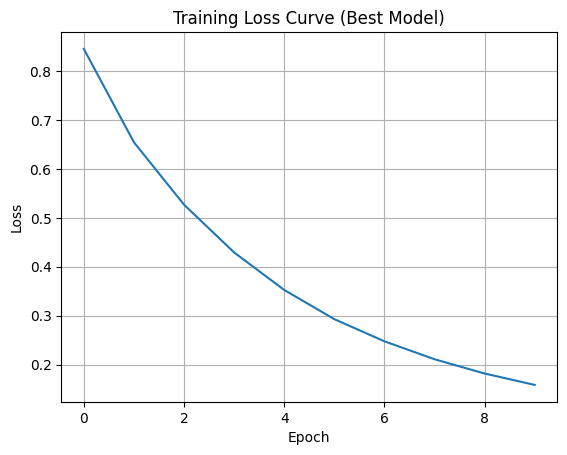

✅ Guardado results/training_curves.png


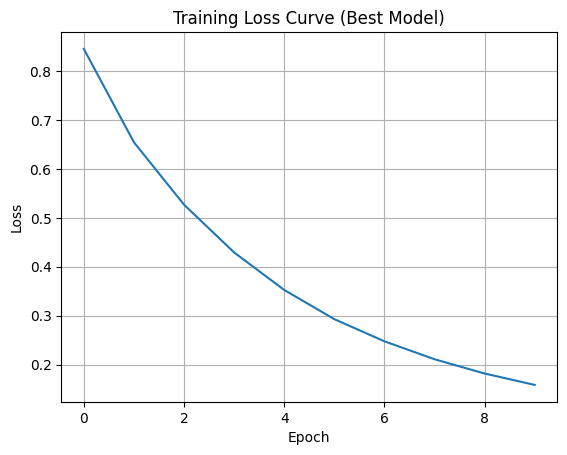

In [33]:
best = res_df.iloc[0].to_dict()
print("🏆 Mejor config:", best)

best_layers = eval(best["arch"])  # convierte string a lista
best_nn = NeuralNetwork(
    layers=best_layers,
    activation=best["activation"],
    init=best["init"]
)

history_best = best_nn.train(
    X_train, y_train,
    epochs=int(best["epochs"]),
    lr=float(best["lr"]),
    batch_size=64,
    verbose=True
)

plt.figure()
plt.plot(history_best["loss"])
plt.title("Training Loss Curve (Best Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Guardar figura
plt.figure()
plt.plot(history_best["loss"])
plt.title("Training Loss Curve (Best Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("results/training_curves.png", dpi=200, bbox_inches="tight")
print("✅ Guardado results/training_curves.png")


13. Matriz de confusión.

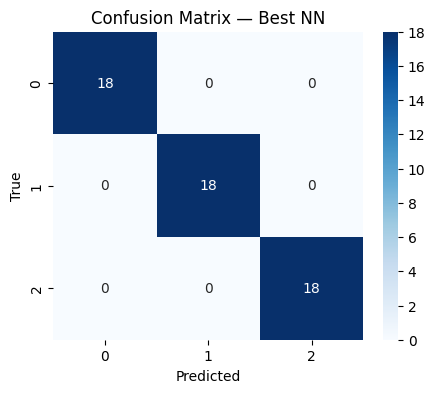

✅ Guardado results/architecture_analysis.png

Reporte final:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        18

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



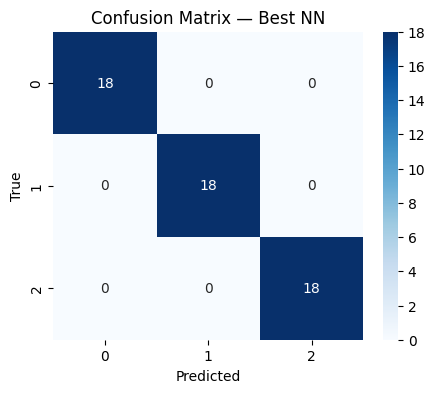

In [34]:
y_pred_best = best_nn.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Best NN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Best NN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("results/architecture_analysis.png", dpi=200, bbox_inches="tight")
print("✅ Guardado results/architecture_analysis.png")

print("\nReporte final:\n", classification_report(y_test, y_pred_best))


14. Guardar el baseline en results/

In [35]:
pd.DataFrame({
    "accuracy": [accuracy_score(y_test, y_pred_base)],
    "f1_weighted": [f1_score(y_test, y_pred_base, average="weighted")]
}).to_csv("results/baseline_metrics.csv", index=False)
